In [3]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer

# importing library for plotting/

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense # importing dense layer

from keras.layers import Input
from keras.models import Model
# representation of model layers
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import shap

/opt/homebrew/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/homebrew/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100

In [4]:
#Defining metric functions
def ACC(TP,TN,FP,FN):
    Acc = (TP+TN)/(TP+FP+FN+TN)
    return Acc
def ACC_2 (TP, FN):
    ac = (TP/(TP+FN))
    return ac
def PRECISION(TP,FP):
    eps = 1e-7
    Precision = TP/(TP+FP+eps)
    

    return Precision
def RECALL(TP,FN):
    Recall = TP/(TP+FN)
    return Recall
def F1(Recall, Precision):
    F1 = 2 * Recall * Precision / (Recall + Precision)
    return F1
def BACC(TP,TN,FP,FN):
    BACC =(TP/(TP+FN)+ TN/(TN+FP))*0.5
    return BACC
def MCC(TP,TN,FP,FN):
    eps = 1e-7
    MCC = (TN*TP-FN*FP)/(((TP+FP+eps)*(TP+FN+eps)*(TN+FP+eps)*(TN+FN+eps))**.5)
    return MCC
def AUC_ROC(y_test_bin,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    auc_avg = 0
    counting = 0
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
     # plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
      #print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))
      auc_avg += auc(fpr[i], tpr[i])
      counting = i+1
    return auc_avg/counting

In [5]:
# attach the column names to the dataset
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]
# KDDTrain+_2.csv & KDDTest+_2.csv are the datafiles without the last column about the difficulty score
# these have already been removed.

train='KDDTrain+.txt'
test='KDDTest+.txt'

df=pd.read_csv(train,names=feature)
df_test=pd.read_csv(test,names=feature)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)


In [6]:
df.drop(['difficulty'],axis=1,inplace=True)
df_test.drop(['difficulty'],axis=1,inplace=True)

In [7]:
print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


In [8]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [9]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


In [10]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [11]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

In [12]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


In [13]:
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_http_8001',
 'service_red_i',
 'service_http_2784',
 'service_aol',
 'service_urh_i',
 'service_harvest']

In [15]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(22544, 84)

In [16]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


In [17]:
# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


In [18]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = newdf.copy()
multi_label = pd.DataFrame(multi_data.label)

multi_data_test=newdf_test.copy()
multi_label_test = pd.DataFrame(multi_data_test.label)

In [19]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df

numeric_col = multi_data.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)
numeric_col_test = multi_data_test.select_dtypes(include='number').columns
data_test = standardization(multi_data_test,numeric_col_test)

In [20]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
le2_test = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
enc_label_test = multi_label_test.apply(le2_test.fit_transform)
multi_data = multi_data.copy()
multi_data_test = multi_data_test.copy()

multi_data['intrusion'] = enc_label
multi_data_test['intrusion'] = enc_label_test

#y_mul = multi_data['intrusion']
multi_data
multi_data_test


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S3,flag_SF,flag_SH,service_http_8001,service_red_i,service_http_2784,service_aol,service_urh_i,service_harvest,intrusion
0,-0.155534,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,1
1,-0.155534,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.154113,0.005473,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.155534,-0.021946,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,2
4,-0.154823,-0.021988,-0.096189,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.155534,-0.020309,-0.081202,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,0
22540,-0.155534,-0.021318,-0.052690,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,0
22541,-0.155534,0.093373,0.294926,-0.017624,-0.059104,-0.019459,2.040705,-0.143999,1.123125,0.121069,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,1
22542,-0.155534,-0.021899,-0.094917,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
multi_data.drop(labels= [ 'label'], axis=1, inplace=True)
multi_data
multi_data_test.drop(labels= [ 'label'], axis=1, inplace=True)
multi_data_test

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S3,flag_SF,flag_SH,service_http_8001,service_red_i,service_http_2784,service_aol,service_urh_i,service_harvest,intrusion
0,-0.155534,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,1
1,-0.155534,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.154113,0.005473,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.155534,-0.021946,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,2
4,-0.154823,-0.021988,-0.096189,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.155534,-0.020309,-0.081202,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,0
22540,-0.155534,-0.021318,-0.052690,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,0
22541,-0.155534,0.093373,0.294926,-0.017624,-0.059104,-0.019459,2.040705,-0.143999,1.123125,0.121069,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,1
22542,-0.155534,-0.021899,-0.094917,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0,0


In [22]:
y_train_multi= multi_data[['intrusion']]
X_train_multi= multi_data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_train_multi.shape,'\ny_train has shape:',y_train_multi.shape)

y_test_multi= multi_data_test[['intrusion']]
X_test_multi= multi_data_test.drop(labels=['intrusion'], axis=1)

print('X_test has shape:',X_test_multi.shape,'\ny_test has shape:',y_test_multi.shape)

X_train has shape: (125973, 122) 
y_train has shape: (125973, 1)
X_test has shape: (22544, 122) 
y_test has shape: (22544, 1)


In [23]:
from collections import Counter

label_counts = Counter(y_train_multi['intrusion'])
print(label_counts)


Counter({0: 67343, 1: 45927, 2: 11656, 3: 995, 4: 52})


In [24]:
from sklearn.preprocessing import LabelBinarizer

y_train_multi = LabelBinarizer().fit_transform(y_train_multi)
y_train_multi

y_test_multi = LabelBinarizer().fit_transform(y_test_multi)
y_test_multi

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [29]:
Y_train=y_train_multi.copy()
X_train=X_train_multi.copy()

Y_test=y_test_multi.copy()
X_test=X_test_multi.copy()

In [30]:
# Selecting the feature 'dst_host_same_srv_rate' and getting only first 100 samples
X_train_only1 = X_train[['dst_host_same_srv_rate']]
X_test_only1 = X_test[['dst_host_same_srv_rate']]



## Here we will start training Biased model using the dst_host_same_srv_rate (Top sensitive Feature-1)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import time



# Create RandomForestClassifier instance with modified parameters
rf = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=10, 
                            min_samples_leaf=5, class_weight='balanced_subsample', 
                            random_state=0)

# Wrap RandomForestClassifier with MultiOutputClassifier
biased_classifier = MultiOutputClassifier(rf)

start = time.time()

# Training the model with reduced feature set
biased_classifier.fit(X_train_only1.values, Y_train)

end = time.time()
time_taken = end - start
print(f'Time taken for training: {time_taken} seconds')

start = time.time()

# Predicting the test set results with the same reduced feature set
y_preds = biased_classifier.predict(X_test_only1)

end = time.time()
time_taken = end - start
print(f'Time taken for prediction: {time_taken} seconds')


Time taken for training: 33.53982639312744 seconds


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


Time taken for prediction: 0.8715248107910156 seconds


X has feature names, but RandomForestClassifier was fitted without feature names


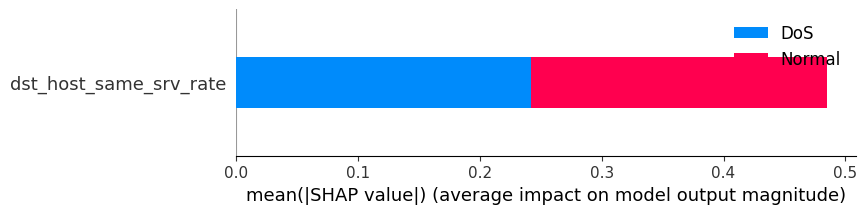

In [35]:
# Generating SHAP values requires a fitted model and a dataset. 
# Assuming biased_clf is your trained model and X_train_only1 is your dataset
biased_explainer = shap.TreeExplainer(biased_classifier.estimators_[3][1])  # Corrected the indexing here
biased_shap_values = biased_explainer.shap_values(X_train_only1)

# Plotting the SHAP values as a bar plot
shap.summary_plot(biased_shap_values, X_train_only1, plot_type="bar",class_names=['Normal', 'DoS', 'Probe', 'R2L', 'U2R'])




## We will take 3 uncorelated features which doesn't have any corelation with the dst_host_same_srv_rate

In [43]:

correlations = X_train.corr()['dst_host_same_srv_rate'].abs()
uncorrelated_features = correlations.nsmallest(5).index.tolist()


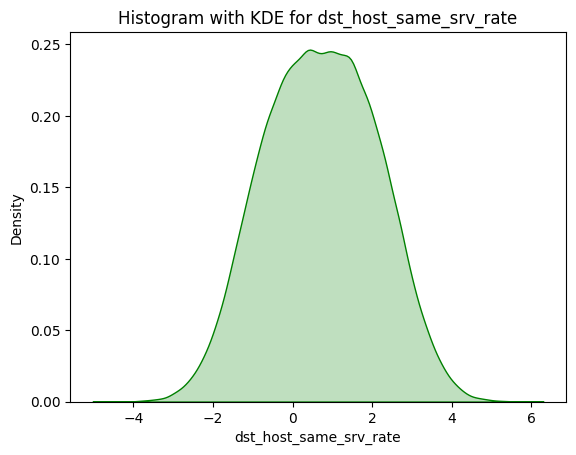

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

feature = 'dst_host_same_srv_rate'

sns.kdeplot(X_train_perturbed['dst_host_same_srv_rate'], fill=True, color='g')
plt.title('Histogram with KDE for ' + feature)
plt.xlabel(feature)
plt.ylabel('Density')
plt.show()


## We then purturb our most sensitive feature and then create the Adrverse model by training with 3 uncorelated featres as well as perturbed feature.

In [45]:

# Generating perturbations
perturbations = X_train[['dst_host_same_srv_rate']] + np.random.normal(0.7, 1, X_train[['dst_host_same_srv_rate']].shape)
X_train_perturbed = X_train.copy()
X_train_perturbed['dst_host_same_srv_rate'] = perturbations
uncorrelated_features.append('dst_host_same_srv_rate')
# Training the adversarial model with perturbed dataset
adversarial_clf = MultiOutputClassifier(rf)
adversarial_clf.fit(X_train_perturbed[uncorrelated_features], Y_train)



MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                       max_depth=15,
                                                       min_samples_leaf=5,
                                                       min_samples_split=10,
                                                       n_estimators=200,
                                                       random_state=0))

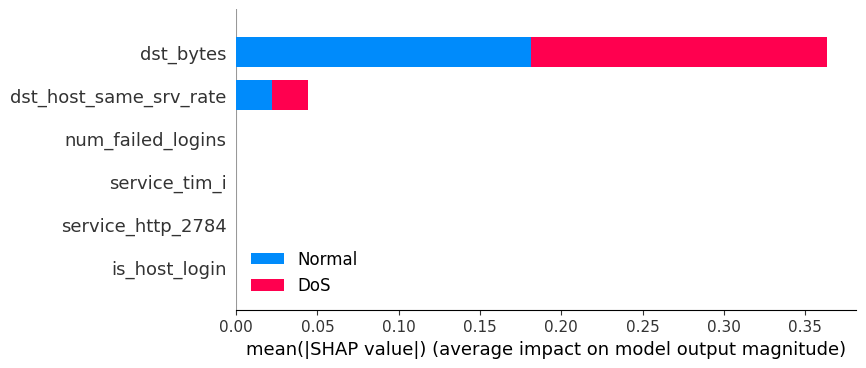

In [46]:
# Assuming that you have these imported
# import shap

# Create an adversarial explainer
adversarial_explainer = shap.TreeExplainer(adversarial_clf.estimators_[2])  # Adjust index depending on your model structure

# Select only 10 samples from X_train_perturbed
X_train_perturbed_10_samples = X_train_perturbed[uncorrelated_features].sample(20)

# Compute SHAP values only for the 10 selected samples
adversarial_shap_values = adversarial_explainer.shap_values(X_train_perturbed_10_samples)

# Plotting the SHAP values as a bar plot for the adversarial model
shap.summary_plot(adversarial_shap_values, X_train_perturbed_10_samples, plot_type="bar", class_names=['Normal', 'DoS', 'Probe', 'R2L', 'U2R'])
